# Named Entity Recognition with DistilBERT on CoNLL-2003 dataset

In [120]:
task = "ner" # could be one of "ner", "pos" or "chunk"
model_checkpoint = "distilbert-base-uncased"
batch_size = 16
label_all_tokens = True

# 1. Loading the dataset

In [121]:
# !pip install evaluate
# !pip install seqeval
from datasets import load_dataset
from evaluate import load
import transformers
import numpy as np
import matplotlib.pyplot as plt

print(transformers.__version__)

from transformers import (
    AutoTokenizer, 
    AutoModelForTokenClassification, 
    TrainingArguments, 
    Trainer, 
    DataCollatorForTokenClassification,
    EarlyStoppingCallback
)

4.47.0


In [122]:
datasets = load_dataset("conll2003",trust_remote_code=True)

In [123]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [124]:
datasets["train"][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [125]:
datasets["train"].features[f"ner_tags"]

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

In [126]:
label_list = datasets["train"].features[f"{task}_tags"].feature.names
label_list

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

# 2. Preprocessing the data

In [127]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [128]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [129]:
tokenize_and_align_labels(datasets['train'][:5])

{'input_ids': [[101, 7327, 19164, 2446, 2655, 2000, 17757, 2329, 12559, 1012, 102], [101, 2848, 13934, 102], [101, 9371, 2727, 1011, 5511, 1011, 2570, 102], [101, 1996, 2647, 3222, 2056, 2006, 9432, 2009, 18335, 2007, 2446, 6040, 2000, 10390, 2000, 18454, 2078, 2329, 12559, 2127, 6529, 5646, 3251, 5506, 11190, 4295, 2064, 2022, 11860, 2000, 8351, 1012, 102], [101, 2762, 1005, 1055, 4387, 2000, 1996, 2647, 2586, 1005, 1055, 15651, 2837, 14121, 1062, 9328, 5804, 2056, 2006, 9317, 10390, 2323, 4965, 8351, 4168, 4017, 2013, 3032, 2060, 2084, 3725, 2127, 1996, 4045, 6040, 2001, 24509, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, -100], [-100, 1, 2, -100], [-100, 5, 0, 

In [130]:
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

# 3. Fine-tuning the model

In [131]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [132]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    report_to = 'none',
    load_best_model_at_end=True,  
    metric_for_best_model="f1", 
    greater_is_better=True,
)

In [133]:
data_collator = DataCollatorForTokenClassification(tokenizer)

metric = load("seqeval")

labels = [label_list[i] for i in example[f"{task}_tags"]]
metric.compute(predictions=[labels], references=[labels])

{'LOC': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'PER': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [134]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [135]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    # tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# 4. Model Training

In [136]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.243700,0.067134,0.905250,0.918112,0.911636,0.979983
2,0.050000,0.062445,0.928651,0.933326,0.930983,0.983558
3,0.027400,0.061116,0.933541,0.939702,0.936611,0.984400
4,0.016400,0.065311,0.924673,0.942052,0.933282,0.984447
5,0.010700,0.073532,0.933519,0.939367,0.936434,0.984161
6,0.006700,0.076026,0.931348,0.940933,0.936116,0.984415


TrainOutput(global_step=5268, training_loss=0.04773538815948034, metrics={'train_runtime': 311.6408, 'train_samples_per_second': 450.551, 'train_steps_per_second': 28.173, 'total_flos': 1022657837357772.0, 'train_loss': 0.04773538815948034, 'epoch': 6.0})

# 5.Model Evaluation

In [137]:
trainer.evaluate()

{'eval_loss': 0.06111577898263931,
 'eval_precision': 0.9335407868415203,
 'eval_recall': 0.9397024275646045,
 'eval_f1': 0.9366114734905503,
 'eval_accuracy': 0.9843995742449998,
 'eval_runtime': 4.2533,
 'eval_samples_per_second': 764.105,
 'eval_steps_per_second': 47.962,
 'epoch': 6.0}

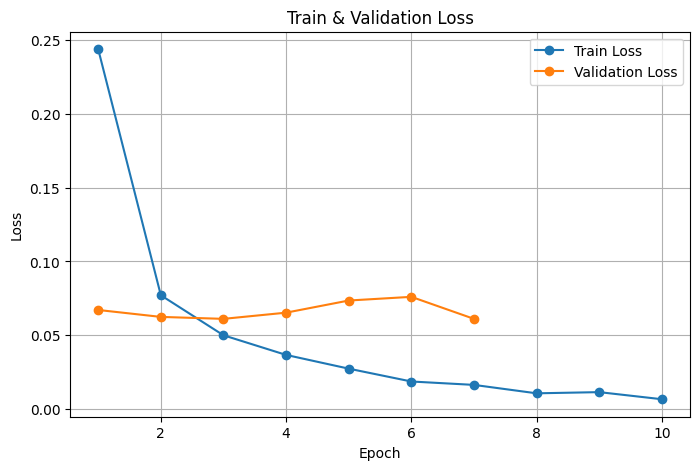

In [144]:
import matplotlib.pyplot as plt


logs = trainer.state.log_history


train_losses = [entry['loss'] for entry in logs if 'loss' in entry]
eval_losses = [entry['eval_loss'] for entry in logs if 'eval_loss' in entry]


epochs_train = list(range(1, len(train_losses) + 1))
epochs_eval = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(8,5))
plt.plot(epochs_train, train_losses, label="Train Loss", marker="o")
plt.plot(epochs_eval, eval_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train & Validation Loss")
plt.grid()
plt.show()

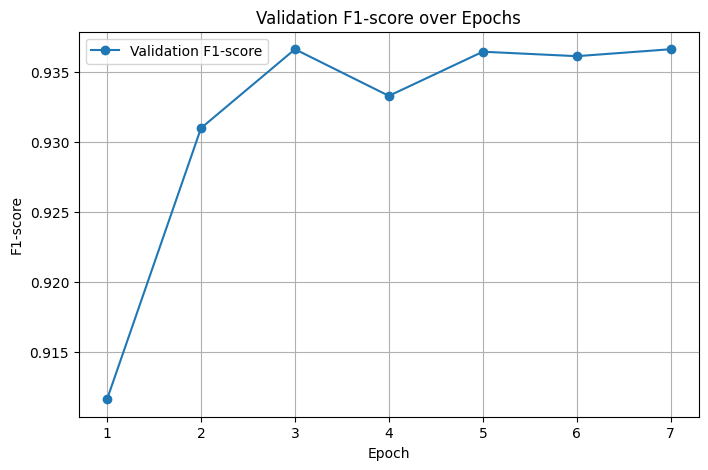

In [145]:
f1_scores = [entry['eval_f1'] for entry in logs if 'eval_f1' in entry]

plt.figure(figsize=(8,5))
plt.plot(range(1, len(f1_scores) + 1), f1_scores, label="Validation F1-score", marker="o")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.legend()
plt.title("Validation F1-score over Epochs")
plt.grid()
plt.show()


In [146]:
test_results = trainer.evaluate(tokenized_datasets["test"])
print(test_results)


{'eval_loss': 0.1302179992198944, 'eval_precision': 0.8887576759565423, 'eval_recall': 0.8931877521955851, 'eval_f1': 0.8909672072925299, 'eval_accuracy': 0.9747427663835371, 'eval_runtime': 4.4779, 'eval_samples_per_second': 771.116, 'eval_steps_per_second': 48.237, 'epoch': 6.0}


In [147]:
predictions, labels, _ = trainer.predict(tokenized_datasets["validation"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
print('Validation set:')
results

Validation set:


{'LOC': {'precision': 0.9549754067347711,
  'recall': 0.9640947288006112,
  'f1': 0.9595134004942026,
  'number': 2618},
 'MISC': {'precision': 0.8406374501992032,
  'recall': 0.8570268074735987,
  'f1': 0.8487530168946099,
  'number': 1231},
 'ORG': {'precision': 0.90478515625,
  'recall': 0.9012645914396887,
  'f1': 0.9030214424951267,
  'number': 2056},
 'PER': {'precision': 0.9724770642201835,
  'recall': 0.978246539222149,
  'f1': 0.97535326979954,
  'number': 3034},
 'overall_precision': 0.9335407868415203,
 'overall_recall': 0.9397024275646045,
 'overall_f1': 0.9366114734905503,
 'overall_accuracy': 0.9843995742449998}

In [149]:
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
print('Test set:')
results

Test set:


{'LOC': {'precision': 0.8725663716814159,
  'recall': 0.928436911487759,
  'f1': 0.8996350364963505,
  'number': 2124},
 'MISC': {'precision': 0.7585492227979275,
  'recall': 0.7349397590361446,
  'f1': 0.7465578786333503,
  'number': 996},
 'ORG': {'precision': 0.875245966155057,
  'recall': 0.8593508500772797,
  'f1': 0.8672255800350945,
  'number': 2588},
 'PER': {'precision': 0.9615099925980755,
  'recall': 0.9558498896247241,
  'f1': 0.958671586715867,
  'number': 2718},
 'overall_precision': 0.8887576759565423,
 'overall_recall': 0.8931877521955851,
 'overall_f1': 0.8909672072925299,
 'overall_accuracy': 0.9747427663835371}